# CES 2018 : Compte-rendu du projet 1

Timothee Papin

## Génération de données artificielles

In [2]:
# Import part
from tp_knn_source import *
import numpy as np

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics.pairwise as mp
from sklearn.metrics import confusion_matrix
from sklearn import datasets, metrics, cross_validation
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression as LR 

import matplotlib.pyplot as plt
import scipy.stats as st

C:\Users\timot\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


La fonction rand_bi_gauss() renvoie un couple (x,y) suivant des lois normales appartenant aux classes 1 ou 2.

Format des data (x,y): (200, 2)
Format du vecteur classe : (200,)


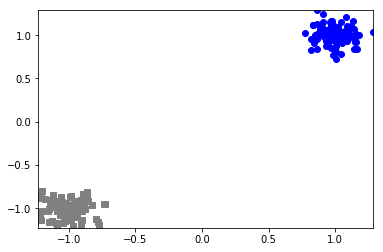

In [2]:
a,b = rand_bi_gauss()
print("Format des data (x,y):", a.shape)
print("Format du vecteur classe :", b.shape)
plot_2d(a,b)

La fonction rand_tri_gauss() renvoie un couple (x,y) suivant des lois normales appartenant aux classes 1, 2 ou 3.

Format des data (x,y): (300, 2)
Format du vecteur classe : (300,)


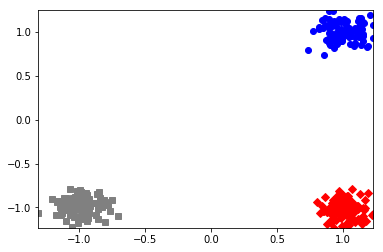

In [114]:
a,b = rand_tri_gauss()
print("Format des data (x,y):", a.shape)
print("Format du vecteur classe :", b.shape)
plot_2d(a,b)

La fonction rand_clown() renvoie un couple (x,y) définit par un mélange de plusieurs variables aléatoires gaussiennes
avec du bruit

A la difference des précédants exemples, on ne peut pas separer les classes 1 et 2 lineairement. Le resultat donne le nez d'un clown qui sourit :)

Format des data (x,y): (1000, 2)
Format du vecteur classe : (1000,)


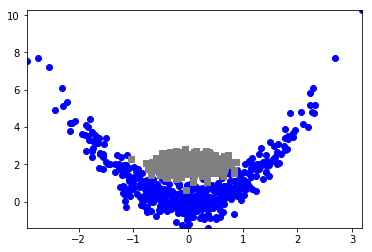

In [96]:
a,b = rand_clown(500,500, sigma1=0.5, sigma2=0.3)
print("Format des data (x,y):", a.shape)
print("Format du vecteur classe :", b.shape)
plot_2d(a,b)

La fonction renvoie un couple (x,y) et 3 classes définit sur un quadrillage 4x4 plus un bruit gaussien.

Format des data (x,y): (10000, 2)
Format du vecteur classe : (10000,)


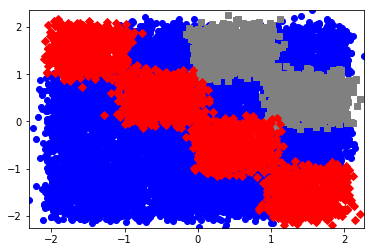

In [5]:
a,b = rand_checkers(5000,5000,0.1)
print("Format des data (x,y):", a.shape)
print("Format du vecteur classe :", b.shape)
plot_2d(a,b)

## Approche intuitive

Pour adapter cette méthode à la régression, nous pouvons la valeur moyenne de y au voisinage de chaque x. 

## Approche formelle

Nous commencons par coder un KNN.

In [39]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=1, weights=None, h=1e3):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.h = h

    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        return self

    def predict(self, X):
        # TODO : Compute all pairwise distances between X and self.X_
        d = mp.pairwise_distances(self.X_,X)

        # TODO : Find the predicted labels y for each entry in X
        y_predict = np.zeros(len(X))
        
        if self.weights is None:
            self.weights = np.ones_like(d)
        else:
            self.weights = get_weights(d,self.h)
        
        for i in range(len(X)):
            #y_predict[i] = st.mode(self.y_[d[:,i].argsort()[0:self.n_neighbors]])[0]
            y_neigh = np.array(self.y_[d[:,i].argsort()[0:self.n_neighbors]],'int')
            w_neigh = self.weights[d[:,i].argsort()[0:self.n_neighbors],i]
            y_predict[i] = np.bincount(y_neigh,weights=w_neigh).argmax()
        # You can use the scipy.stats.mode function

        return y_predict

def get_weights(dist,h):
    """Returns an array of weights, exponentially decreasing in the square
    of the distance.

    Parameters
    ----------
    dist : a one-dimensional array of distances.

    Returns
    -------
    weight : array of the same size as dist
    """
    w = np.exp(-dist*dist/h)
    return w

Testons notre modele et sa performance avec un jeu de données définit par rand_bi_gauss().

In [19]:
x,y = rand_bi_gauss(n1=100, n2=100, mu1=[0.5, 0.5], mu2=[-0.5, -0.5], sigma1=[1, 1], sigma2=[1, 1])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
my = KNNClassifier(n_neighbors=10)
my.fit(x_train,y_train)
y_model = my.predict(x_test)
print('Score de notre KNN: %f' %(sum(y_model==y_test)/len(y_test)))

Score de notre KNN: 0.725000


In [20]:
neigh = KNeighborsClassifier(n_neighbors=10,p=2)
neigh.fit(x_train, y_train)
y_model2 = neigh.predict(x_test)
print('Score du KNN Sklearn: %f' %(sum(y_model2==y_test)/len(y_test)))

Score du KNN Sklearn: 0.725000


Affichons les jeux de donnees d'apprentissage et de test, ainsi que la frontiere entre les 2 classes.

Text(0.5,1,'Frontiere')

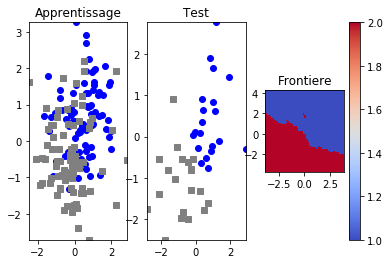

In [42]:
plt.subplot(1, 3, 1)
plot_2d(x_train,y_train)
plt.title('Apprentissage')
plt.subplot(1, 3, 2)
plot_2d(x_test,y_model2)
plt.title('Test')
plt.subplot(1, 3, 3)
frontiere(neigh.predict,x)
plt.title('Frontiere')

Idem pour le jeu de données rand_tri_gauss(). 
Affichons les jeux de donnees d'apprentissage et de test, ainsi que la frontiere entre les 3 classes.

Text(0.5,1,'Frontiere')

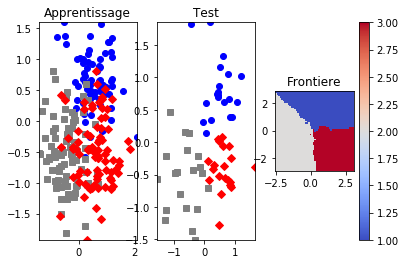

In [106]:
x,y = rand_tri_gauss(n1=100, n2=100, n3=100, mu1=[0.5, 0.5],
                   mu2=[-0.5, -0.5], mu3=[0.5, -0.5], sigma1=[0.5, 0.5],
                   sigma2=[0.5, 0.5], sigma3=[0.5, 0.5])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
neigh = KNeighborsClassifier(n_neighbors=10,p=2)
neigh.fit(x_train, y_train)
y_model2 = neigh.predict(x_test)

plt.subplot(1, 3, 1)
plot_2d(x_train,y_train)
plt.title('Apprentissage')
plt.subplot(1, 3, 2)
plot_2d(x_test,y_model2)
plt.title('Test')
plt.subplot(1, 3, 3)
frontiere(neigh.predict,x)
plt.title('Frontiere')

Idem pour le jeu de données rand_clown(). 
Affichons les jeux de donnees d'apprentissage et de test, ainsi que la frontiere entre les 2 classes.

Text(0.5,1,'Frontiere')

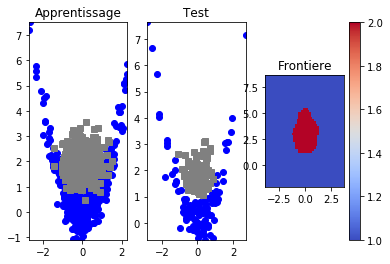

In [15]:
x,y = rand_clown(n1=500, n2=500, sigma1=0.5, sigma2=0.5)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
neigh = KNeighborsClassifier(n_neighbors=10,p=2)
neigh.fit(x_train, y_train)
y_model2 = neigh.predict(x_test)

plt.subplot(1, 3, 1)
plot_2d(x_train,y_train)
plt.title('Apprentissage')
plt.subplot(1, 3, 2)
plot_2d(x_test,y_model2)
plt.title('Test')
plt.subplot(1, 3, 3)
frontiere(neigh.predict,x)
plt.title('Frontiere')

Idem pour le jeu de données rand_checkers(). 
Affichons les jeux de donnees d'apprentissage et de test, ainsi que la frontiere entre les 3 classes.

Text(0.5,1,'Frontiere')

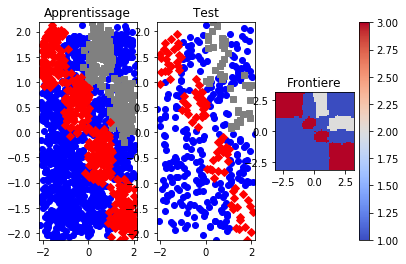

In [107]:
x,y = rand_checkers(n1=1000, n2=1000, sigma=0.1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
neigh = KNeighborsClassifier(n_neighbors=10,p=2)
neigh.fit(x_train, y_train)
y_model2 = neigh.predict(x_test)

plt.subplot(1, 3, 1)
plot_2d(x_train,y_train)
plt.title('Apprentissage')
plt.subplot(1, 3, 2)
plot_2d(x_test,y_model2)
plt.title('Test')
plt.subplot(1, 3, 3)
frontiere(neigh.predict,x)
plt.title('Frontiere')

Testons différents k=1 et k=N pour le jeu de données rand_bi_gauss()

Erreur pour k=1: 0.125000
Erreur pour k=N: 0.562500


Text(0.5,1,'Frontiere pour k=N')

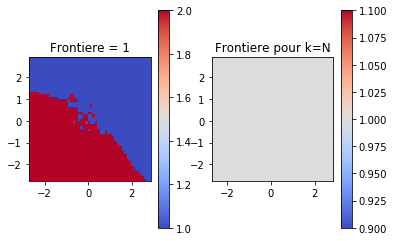

In [85]:
x,y = rand_bi_gauss(n1=200, n2=200, mu1=[0.5, 0.5], mu2=[-0.5, -0.5], sigma1=[0.5, 0.5], sigma2=[0.5, 0.5])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

neigh1 = KNeighborsClassifier(n_neighbors=1,p=2)
neigh1.fit(x_train, y_train)
y_model1 = neigh1.predict(x_test)
score1 = sum(y_model1==y_test)/len(y_test)

neighN = KNeighborsClassifier(n_neighbors=320,p=2) #ici n = (1-0.2)x(n1+n2)
neighN.fit(x_train, y_train)
y_modelN = neighN.predict(x_test)
scoreN = sum(y_modelN==y_test)/len(y_test)

print('Erreur pour k=1: %f' % (1-score1))
print('Erreur pour k=N: %f' % (1-scoreN))

plt.subplot(1, 2, 1)
frontiere(neigh1.predict,x)
plt.title('Frontiere = 1')

plt.subplot(1, 2, 2)
frontiere(neighN.predict,x)
plt.title('Frontiere pour k=N')

Pour k=1 le modele n'est pas parfait mais fonctionne alors que pour k=N le modele, en prenant tous les observations comme
 voisins, ne sait plus faire la dictintion entre la classe 1 ou 2! 

Testons différents k=1 et k=N pour le jeu de données rand_tri_gauss()

Erreur pour k=1: 0.316667
Erreur pour k=N: 0.716667


Text(0.5,1,'Frontiere pour k=N')

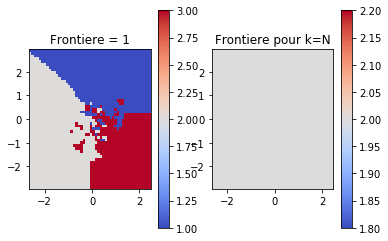

In [86]:
x,y = rand_tri_gauss(n1=100, n2=100, n3=100, mu1=[0.5, 0.5],
                   mu2=[-0.5, -0.5], mu3=[0.5, -0.5], sigma1=[0.5, 0.5],
                   sigma2=[0.5, 0.5], sigma3=[0.5, 0.5])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

neigh1 = KNeighborsClassifier(n_neighbors=1,p=2)
neigh1.fit(x_train, y_train)
y_model1 = neigh1.predict(x_test)
score1 = sum(y_model1==y_test)/len(y_test)

neighN = KNeighborsClassifier(n_neighbors=240,p=2) #ici n = (1-0.2)x(n1+n2+n3)
neighN.fit(x_train, y_train)
y_modelN = neighN.predict(x_test)
scoreN = sum(y_modelN==y_test)/len(y_test)

print('Erreur pour k=1: %f' % (1-score1))
print('Erreur pour k=N: %f' % (1-scoreN))

plt.subplot(1, 2, 1)
frontiere(neigh1.predict,x)
plt.title('Frontiere = 1')

plt.subplot(1, 2, 2)
frontiere(neighN.predict,x)
plt.title('Frontiere pour k=N')

Pour k=1 le modele a du mal definir les 3 regions au centre . Pour k=N le modele, en prenant tous les observations comme
 voisins, ne sait plus faire la dictintion entre la classe 1, 2 ou 3! 

Testons différents k=1 et k=N pour le jeu de données rand_clown().

Erreur pour k=1: 0.110000
Erreur pour k=N: 0.510000


Text(0.5,1,'Frontiere pour k=N')

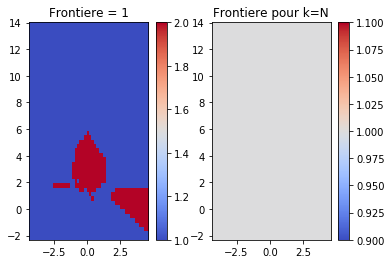

In [87]:
x,y = rand_clown(n1=500, n2=500, sigma1=0.5, sigma2=0.5)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

neigh1 = KNeighborsClassifier(n_neighbors=1,p=2)
neigh1.fit(x_train, y_train)
y_model1 = neigh1.predict(x_test)
score1 = sum(y_model1==y_test)/len(y_test)

neighN = KNeighborsClassifier(n_neighbors=800,p=2) #ici n = (1-0.2)x(n1+n2)
neighN.fit(x_train, y_train)
y_modelN = neighN.predict(x_test)
scoreN = sum(y_modelN==y_test)/len(y_test)

print('Erreur pour k=1: %f' % (1-score1))
print('Erreur pour k=N: %f' % (1-scoreN))

plt.subplot(1, 2, 1)
frontiere(neigh1.predict,x)
plt.title('Frontiere = 1')

plt.subplot(1, 2, 2)
frontiere(neighN.predict,x)
plt.title('Frontiere pour k=N')

Pour k=1 le modele fonctionne bien. Pour k=N le modele, en prenant tous les observations comme
 voisins, ne sait plus faire la dictintion entre la classe 1 ou 2! 

Testons différents k=1 et k=N pour le jeu de données rand_checkers().

Erreur pour k=1: 0.140000
Erreur pour k=N: 0.372500


Text(0.5,1,'Frontiere pour k=N')

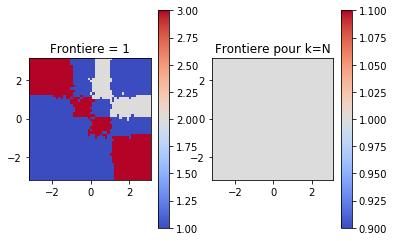

In [88]:
x,y = rand_checkers(n1=1000, n2=1000, sigma=0.1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

neigh1 = KNeighborsClassifier(n_neighbors=1,p=2)
neigh1.fit(x_train, y_train)
y_model1 = neigh1.predict(x_test)
score1 = sum(y_model1==y_test)/len(y_test)

neighN = KNeighborsClassifier(n_neighbors=1600,p=2) #ici n = (1-0.2)x(n1+n2)
neighN.fit(x_train, y_train)
y_modelN = neighN.predict(x_test)
scoreN = sum(y_modelN==y_test)/len(y_test)

print('Erreur pour k=1: %f' % (1-score1))
print('Erreur pour k=N: %f' % (1-scoreN))

plt.subplot(1, 2, 1)
frontiere(neigh1.predict,x)
plt.title('Frontiere = 1')

plt.subplot(1, 2, 2)
frontiere(neighN.predict,x)
plt.title('Frontiere pour k=N')

Pour k=1, le modele fonctionne pas très bien aux frontieres. Pour k=N le modele, en prenant tous les observations comme
 voisins, ne sait plus faire la dictintion entre la classe 1 ou 2! 

Nous ajoutons un poids pour chaque voisin et testons le choix du h sur la fonction.

Score pour h=1.000000: 0.733333
Score pour h=0.100000: 0.733333
Score pour h=0.010000: 0.766667
Score pour h=0.001000: 0.716667
Score pour h=0.000100: 0.716667
Score pour h=0.000010: 0.400000


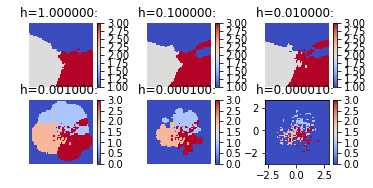

In [85]:
x,y = rand_tri_gauss(n1=100, n2=100, n3=100, mu1=[0.5, 0.5],
                   mu2=[-0.5, -0.5], mu3=[0.5, -0.5], sigma1=[0.5, 0.5],
                   sigma2=[0.5, 0.5], sigma3=[0.5, 0.5])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

i = 1
for k in np.power(0.1,range(6)):
    my = KNNClassifier(n_neighbors=10,weights='function',h=k)
    my.fit(x_train,y_train)
    y_model = my.predict(x_test)
    print('Score pour h=%f: %f' %(k, (sum(y_model==y_test)/len(y_test))))
    plt.axis('off')
    plt.subplot(3, 3, i)
    frontiere(my.predict,x)
    plt.title('h=%f: ' %k)
    i = i+1

Le h optimal change en fonction du tirage ou du jeu de donnees. Cependant quand h devient trop petit, toutes les distances se confondent et les poids deviennent trop petits pour que le modele choisisse l'etat optimal de chaque observation.

Etudions le taux d'erreur en fonction du k choisi pour différentes tailles de jeu de donnees [100, 500, 1000].

Pour N = 100, meilleur k = 36 ou erreur = 0.000000
Pour N = 500, meilleur k = 16 ou erreur = 0.060000
Pour N = 1000, meilleur k = 21 ou erreur = 0.080000


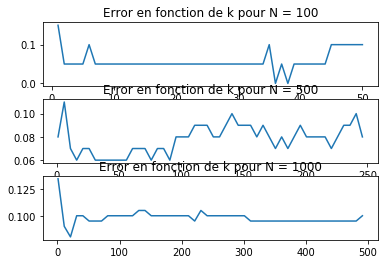

In [143]:
N = np.array([100,500,1000],'int')
i = 1
for n in N:
    x,y = rand_bi_gauss(n1=n//2, n2=n//2, mu1=[0.5, 0.5], mu2=[-0.5, -0.5], sigma1=[0.5, 0.5], sigma2=[0.5, 0.5])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    vk = np.dot(range(0,50),n//100)+1
    errork = []
    for k in vk:
        neigh = KNeighborsClassifier(n_neighbors=k,p=2)
        neigh.fit(x_train, y_train)
        y_model = neigh.predict(x_test)
        errork.append(1 - sum(y_model==y_test)/len(y_test))
        #print('Erreur pour k=%i: %f' %(k, error))

    plt.subplot(3, 1, i)
    plt.plot(vk,errork)
    plt.title('Error en fonction de k pour N = %i' %n)
    print('Pour N = %i, meilleur k = %i ou erreur = %f' %(n,vk[np.array(errork).argmin()],np.array(errork).min()))
    i += 1


Pour N = 100, meilleur k = 13 ou erreur = 0.200000
Pour N = 500, meilleur k = 191 ou erreur = 0.290000
Pour N = 1000, meilleur k = 161 ou erreur = 0.185000


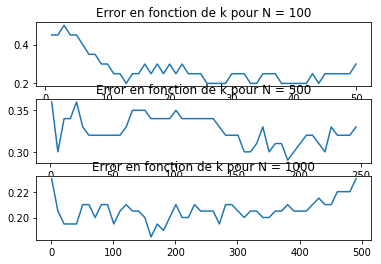

In [141]:
N = np.array([100,500,1000],'int')
i = 1
for n in N:
    x,y = rand_tri_gauss(n1=n//3, n2=n//3, n3=n//3, mu1=[0.5, 0.5],
                   mu2=[-0.5, -0.5], mu3=[0.5, -0.5], sigma1=[0.5, 0.5],
                   sigma2=[0.5, 0.5], sigma3=[0.5, 0.5])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    vk = np.dot(range(0,50),n//100)+1
    errork = []
    for k in vk:
        neigh = KNeighborsClassifier(n_neighbors=k,p=2)
        neigh.fit(x_train, y_train)
        y_model = neigh.predict(x_test)
        errork.append(1 - sum(y_model==y_test)/len(y_test))
        #print('Erreur pour k=%i: %f' %(k, error))

    plt.subplot(3, 1, i)
    plt.plot(vk,errork)
    plt.title('Error en fonction de k pour N = %i' %n)
    print('Pour N = %i, meilleur k = %i ou erreur = %f' %(n,vk[np.array(errork).argmin()],np.array(errork).min()))
    i += 1


Pour N = 100, meilleur k = 13 ou erreur = 0.050000
Pour N = 500, meilleur k = 6 ou erreur = 0.030000
Pour N = 1000, meilleur k = 31 ou erreur = 0.050000


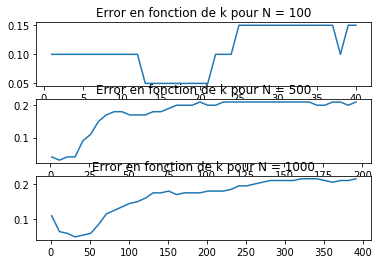

In [138]:
N = np.array([100,500,1000],'int')
i = 1
for n in N:
    x,y = rand_clown(n1=n//2, n2=n//2, sigma1=0.5, sigma2=0.5)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    vk = np.dot(range(0,50),n//100)+1
    errork = []
    for k in vk:
        neigh = KNeighborsClassifier(n_neighbors=k,p=2)
        neigh.fit(x_train, y_train)
        y_model = neigh.predict(x_test)
        errork.append(1 - sum(y_model==y_test)/len(y_test))
        #print('Erreur pour k=%i: %f' %(k, error))

    plt.subplot(3, 1, i)
    plt.plot(vk,errork)
    plt.title('Error en fonction de k pour N = %i' %n)
    print('Pour N = %i, meilleur k = %i ou erreur = %f' %(n,vk[np.array(errork).argmin()],np.array(errork).min()))
    i += 1


Pour N = 100, meilleur k = 2 ou erreur = 0.250000
Pour N = 500, meilleur k = 11 ou erreur = 0.160000
Pour N = 1000, meilleur k = 11 ou erreur = 0.160804


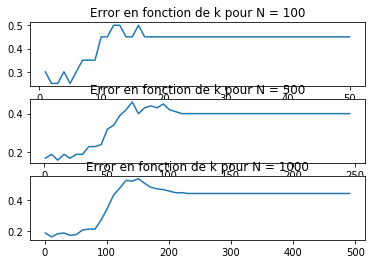

In [137]:
N = np.array([100,500,1000],'int')
i = 1
for n in N:
    x,y = rand_checkers(n1=n//2, n2=n//2, sigma=0.1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    vk = np.dot(range(0,50),n//100)+1
    errork = []
    for k in vk:
        neigh = KNeighborsClassifier(n_neighbors=k,p=2)
        neigh.fit(x_train, y_train)
        y_model = neigh.predict(x_test)
        errork.append(1 - sum(y_model==y_test)/len(y_test))
        #print('Erreur pour k=%i: %f' %(k, error))

    plt.subplot(3, 1, i)
    plt.plot(vk,errork)
    plt.title('Error en fonction de k pour N = %i' %n)
    print('Pour N = %i, meilleur k = %i ou erreur = %f' %(n,vk[np.array(errork).argmin()],np.array(errork).min()))
    i += 1

Au vue de cette etude, je trouve que la methode des KNN est parfois tres instable et difficile a calibrer. L'interpretation est parfois difficile. En effet, nous avons vu qu'il existe beaucoup de combinaisons possibles (k, n, h, norme, poids ou non...). Elle a cependant l'avantage de donnees des resultats pour des classifications non lineaires. Nous ne l'avons pas vu ici mais la methode des KNN est limitée pour des dimensions élevées. Ici, nous sommes restés en dimension 2. J'ai trouvé les temps de calcul assez courts.

Appliquons la methode KNN au jeu de donnees "Digits".

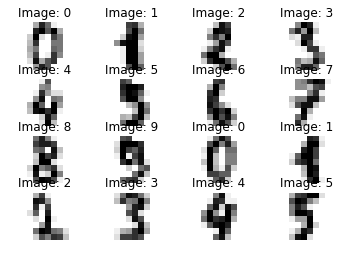

In [3]:
digits = datasets.load_digits()
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:16]):
    plt.subplot(4, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Image: %i' % label)

In [162]:
y = digits.target
x = digits.data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [166]:
neigh = KNeighborsClassifier(n_neighbors=1,p=2)
neigh.fit(x_train, y_train)
y_model = neigh.predict(x_test)
erreur = 1- sum(y_test == y_model) / len(y_test)

print('Pour k = 1, erreur = %f' % erreur)

Pour k = 1, erreur = 0.002778


Text(0.5,1,'Error en fonction de k')

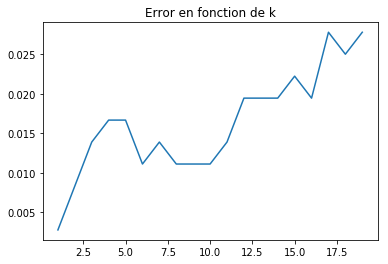

In [175]:
vk = range(1,20)
errork = []
for k in vk:
    neigh = KNeighborsClassifier(n_neighbors=k,p=2)
    neigh.fit(x_train, y_train)
    y_model = neigh.predict(x_test)
    errork.append(1 - sum(y_model==y_test)/len(y_test))
        
plt.plot(vk,errork)
plt.title('Error en fonction de k')

L'erreur est minimiser pour k = 1.

In [186]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[35  0  0  0  1  0  0  0  0  0]
 [ 0 46  0  0  0  0  0  0  0  0]
 [ 1  0 41  0  0  0  0  0  0  0]
 [ 0  0  0 36  0  1  0  0  1  0]
 [ 0  0  0  0 32  0  0  0  0  0]
 [ 0  0  0  0  0 32  0  0  0  0]
 [ 1  0  0  0  0  0 37  0  1  0]
 [ 0  0  0  0  0  0  0 30  0  1]
 [ 0  0  1  1  0  0  0  0 34  0]
 [ 0  0  0  0  0  1  0  0  0 27]]


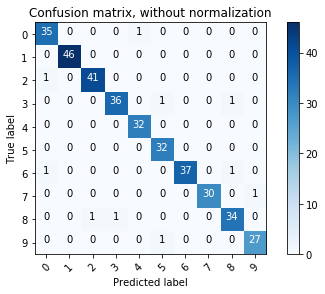

In [187]:
cnf_matrix = confusion_matrix(y_test, y_model)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(0,10), title='Confusion matrix, without normalization')

plt.show()

## Aspect théorique

Pour $X$ continu et $Y$ discret, le théorème de Bayes nous dit que
$$f_{X\,\mid\,Y=y}(x) = \frac{P(Y=y\mid X=x)\,f_X(x)}{P(Y=y)}$$
Avec les notations données dans l'énoncé on peut écrire,
$$P(Y=+1\mid X=x) = \frac{f_{+}(x)\pi_{+}}{f_X(x)}$$
et
$$P(Y=-1\mid X=x) = \frac{f_{-}(x)(1-\pi_{+})}{f_X(x)}$$
En remplacant $f_X(x)$ par,
$$f_X(x)=f_{+}(x)\pi_{+}+f_{-}(x)(1-\pi_{+})$$
On obtient,
$$P(Y=+1\mid X=x) = \frac{f_{+}(x)\pi_{+}}{f_{+}(x)\pi_{+}+f_{-}(x)(1-\pi_{+})}$$
et
$$P(Y=-1\mid X=x) = \frac{f_{-}(x)(1-\pi_{+})}{f_{+}(x)\pi_{+}+f_{-}(x)(1-\pi_{+})}$$

Connaissant les densités $f_{+}$ et $f_{-}$, le log-ratio des 2 classes peut s'écrire,
$$log(\frac{P(Y=+1\mid X=x)}{P(Y=-1\mid X=x)}=log(\frac{f_{+}(x)\pi_{+}}{f_{-}(x)(1-\pi_{+})})$$
$$=log(\frac{\pi_{+}}{1-\pi_{+}})-\frac{1}{2}(x-\mu_{+})^{T}\Sigma^{-1}(x-\mu_{+})+\frac{1}{2}(x-\mu_{-})^{T}\Sigma^{-1}(x-\mu_{-})$$
$$=log(\frac{\pi_{+}}{1-\pi_{+}})+x^{T}\Sigma^{-1}(\mu_{+}-\mu_{-})-\frac{1}{2}(\mu_{+}-\mu_{-})^{T}\Sigma^{-1}(\mu_{+}-\mu_{-})$$

A partir d'un échantillon de $n$ observations où $\sum_{i\in [1,n]}\mathbb{1}(y_{i}=+1)=m$, on déduit les estimateurs suivants,
$$\hat{\pi}_{+}=\frac{m}{n}$$
$$\hat{\mu}_{+}=\frac{1}{m}\sum_{i\in [1,n]}x_{i}\mathbb{1}(y_{i}=+1)$$
$$\hat{\mu}_{-}=\frac{1}{n-m}\sum_{i\in [1,n]}x_{i}\mathbb{1}(y_{i}=-1)$$
$$\hat{\Sigma}=\frac{1}{2}\left(\frac{1}{m}\sum_{i\in [1,n]}(x_{i}-\hat{\mu}_{+})(x_{i}-\hat{\mu}_{+})^{T}\mathbb{1}(y_{i}=+1)+\frac{1}{n-m}\sum_{i\in [1,n]}(x_{i}-\hat{\mu}_{-})(x_{i}-\hat{\mu}_{-})^{T}\mathbb{1}(y_{i}=-1)\right)$$

La frontière est définie par la droite séparatrice ci-dessous,
$$log(\frac{\pi_{+}}{1-\pi_{+}})+x^{T}\Sigma^{-1}(\mu_{+}-\mu_{-})-\frac{1}{2}(\mu_{+}-\mu_{-})^{T}\Sigma^{-1}(\mu_{+}-\mu_{-})$$
En utilisant les estimateurs obtenus à partir de notre échantillon, on obtient,
$$log(\frac{m}{n})-log(1-\frac{m}{n})+x^{T}\hat{\Sigma}^{-1}(\hat{\mu}_{+}-\hat{\mu}_{-})-\frac{1}{2}(\hat{\mu}_{+}-\hat{\mu}_{-})^{T}\hat{\Sigma}^{-1}(\hat{\mu}_{+}-\hat{\mu}_{-})=0$$
Le classificateur renverra donc $+1$ au dessus de la frontière et $-1$ en dessous.

Si les matrices de covariance ne sont pas identiques, nous aurons une analyse quadratique avec une frontière non linéaire.

Dans le cas d'une analyse discriminante linéaire multi-classes, la dérivation du discriminant de Fisher peut être étendue pour trouver un sous-espace contenant toutes les classes.

## Mise en oeuvre

Cas de gaussiennes isotropes:

Erreur de notre LDA: 0.216667


Text(0.5,1,'Frontiere')

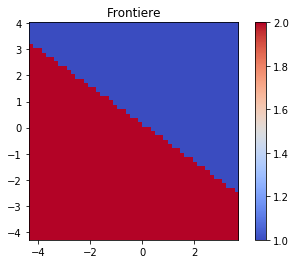

In [8]:
x,y = rand_bi_gauss(n1=100, n2=100, mu1=[0.5, 0.5], mu2=[-0.5, -0.5], sigma1=[1, 1], sigma2=[1, 1])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
my = LDA()
my.fit(x_train,y_train)
y_model = my.predict(x_test)
print('Erreur de notre LDA: %f' %(1-sum(y_model==y_test)/len(y_test)))
frontiere(my.predict,x)
plt.title('Frontiere')

Cas de gaussiennes anisotropes:

Erreur de notre LDA: 0.216667


Text(0.5,1,'Frontiere')

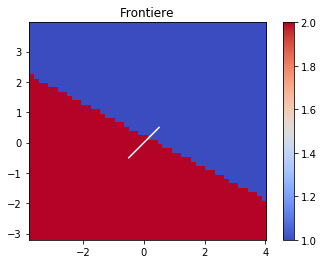

In [26]:
x,y = rand_bi_gauss(n1=100, n2=100, mu1=[0.5, 0.5], mu2=[-0.5, -0.5], sigma1=[1, 1], sigma2=[1, 0.5])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
my = LDA()
my.fit(x_train,y_train)
y_model = my.predict(x_test)
print('Erreur de notre LDA: %f' %(1-sum(y_model==y_test)/len(y_test)))
frontiere(my.predict,x)
plt.plot([0.5, -0.5],[0.5, -0.5],color='white')
plt.title('Frontiere')

On observe que la frontière ne passe plus par la médiatrice du segment entre les moyennes $\mu_{1}$ et  $\mu_{2}$ (segment blanc).

## Méthode discriminante avec régression logistique

In [41]:
x,y = rand_bi_gauss(n1=500, n2=100, mu1=[0.5, 0.5], mu2=[-0.5, -0.5], sigma1=[1, 1], sigma2=[1, 1])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
myLR = LR()
myLR.fit(x_train,y_train)
y_modelLR = myLR.predict(x_test)
print('Erreur de notre LR: %f' %(1-sum(y_modelLR==y_test)/len(y_test)))
myLDA = LDA()
myLDA.fit(x_train,y_train)
y_modelLDA = myLDA.predict(x_test)
print('Erreur de notre LDA: %f' %(1-sum(y_modelLDA==y_test)/len(y_test)))

Erreur de notre LR: 0.144444
Erreur de notre LDA: 0.144444


Nous obtenons des résultats très proches avec mes 2 modèles LDA et LR.

La variable "coef_" représente les coefficients des caractéristiques X dans la fonction de décision.
La variable "intercept_" représente le biais de la fonction de décision.

Text(0.5,1,'Frontiere du LDA')

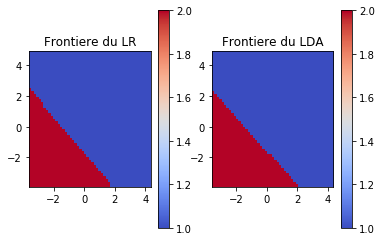

In [42]:
plt.subplot(1, 2, 1)
frontiere(myLR.predict,x)
plt.title('Frontiere du LR')
plt.subplot(1, 2, 2)
frontiere(myLDA.predict,x)
plt.title('Frontiere du LDA')

In [5]:
y = digits.target
x = digits.data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
my = LR()
my.fit(x_train,y_train)
y_model = my.predict(x_test)
print('Erreur de notre LR: %f' %(1-sum(y_model==y_test)/len(y_test)))

Erreur de notre LR: 0.042593


Le parametre de régulation est C = 10


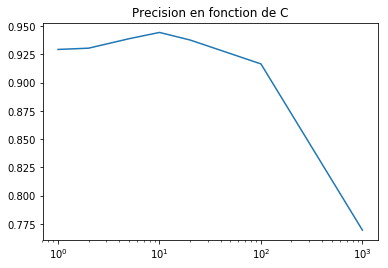

In [41]:
vC = np.array([1,2,5,10,20,100,1000])
errorC = []
for i in vC:
    predicted = cross_validation.cross_val_predict(LR(C=1/i, penalty='l1'), x, y, cv=10)
    errorC.append(metrics.accuracy_score(y, predicted))
        
plt.plot(vC,errorC)
plt.title('Precision en fonction de C')
plt.xscale('log')
print('Le parametre de régulation est C = %i' % vC[np.array(errorC).argmax()])